# Ensemble Learning for a Hidden Markov Model 

In [9]:
using ForneyLab

n_samples = 100
A_data = [0.9 0.1; 0.1 0.9]
B_data = [0.9 0.1; 0.1 0.9]

s_0_data = [1.0, 0.0]

s_data = Vector{Vector{Float64}}(n_samples)
x_data = Vector{Vector{Float64}}(n_samples)
s_t_min_data = s_0_data
for t = 1:n_samples
    a = A_data*s_t_min_data
    s_data[t] = sample(ProbabilityDistribution(Categorical, p=a./sum(a))) # Evolution model
    b = B_data*s_data[t]
    x_data[t] = sample(ProbabilityDistribution(Categorical, p=b./sum(b))) # Observation model
    
    s_t_min_data = s_data[t]
end
;

# Build

In [10]:
g = FactorGraph()

@RV A ~ Dirichlet(constant([5.0 1.0; 1.0 5.0]), id=:A)
@RV B ~ Dirichlet(constant([5.0 1.0; 1.0 5.0]), id=:B)
@RV s_0 ~ Categorical(constant([0.5, 0.5]), id=:s_0)

s = Vector{Variable}(n_samples)
x = Vector{Variable}(n_samples)
s_t_min = s_0
for t = 1:n_samples
    @RV s[t] ~ Transition(s_t_min, A, id=:s_*t)
    @RV x[t] ~ Transition(s[t], B, id=:x_*t)
    
    s_t_min = s[t]
    
    placeholder(x[t], :x, index=t, datatype=Float64, dims=(2,))
end
;

# Schedule

In [11]:
rf = RecognitionFactorization()

# Define the recognition factorization
q_A = RecognitionFactor(A)
q_B = RecognitionFactor(B)
q_s = RecognitionFactor([s_0; s])

# Compile algorithm
algo_q_A = variationalAlgorithm(q_A, name="A")
algo_q_B = variationalAlgorithm(q_B, name="B")
algo_q_s = variationalAlgorithm(q_s, name="S")
algo_F = freeEnergyAlgorithm()
;

# Infer

In [12]:
# Load algorithm
eval(parse(algo_q_A))
eval(parse(algo_q_B))
eval(parse(algo_q_s))
eval(parse(algo_F))

# Initial recognition distributions
marginals = Dict{Symbol, ProbabilityDistribution}(
    :A => vague(Dirichlet, (2,2)),
    :B => vague(Dirichlet, (2,2)))

for t = 1:n_samples
    marginals[Symbol("s_$(t)_s_$(t-1)")] = vague(Contingency, (2,2))
end

# Initialize data
data = Dict(:x => x_data)
n_its = 20

# Run algorithm
F = Vector{Float64}(n_its)
for i = 1:n_its
    stepS!(data, marginals)
    stepB!(data, marginals)
    stepA!(data, marginals)

    F[i] = freeEnergy(data, marginals)
end
;

# Results

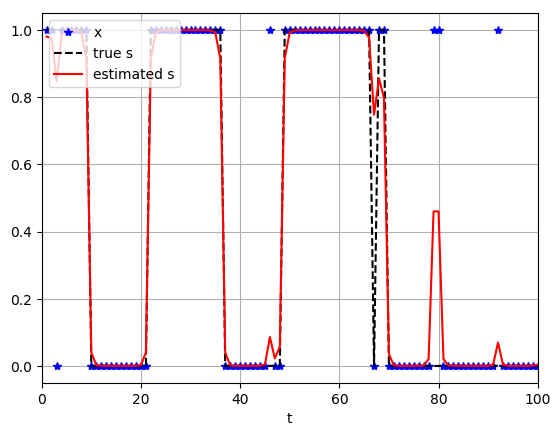

In [13]:
using PyPlot

# Collect state estimates
x_obs = [x_i[1] for x_i in x_data]
s_true = [s_i[1] for s_i in s_data]
m_s = [mean(marginals[:s_*t])[1] for t=1:n_samples]

# Plot estimated state
plot(1:n_samples, x_obs, "b*", label="x")
plot(1:n_samples, s_true, "k--", label="true s")
plot(1:n_samples, m_s, "r-", label="estimated s")

grid("on")
xlabel("t")
legend(loc="upper left")
xlim(0,n_samples);

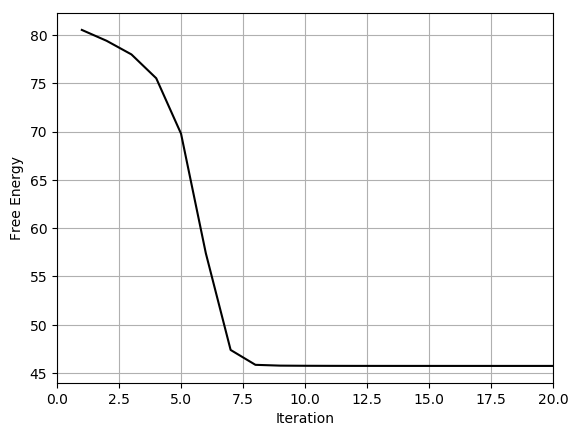

In [14]:
# Plot free energy
plot(1:n_its, F, color="black")

grid("on")
# yscale("log")
xlabel("Iteration")
ylabel("Free Energy")
xlim(0,n_its);